<a href="https://colab.research.google.com/github/MiddleSouth/RPGBattleAI/blob/master/RPGTurnBattleWithAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# このアプリの使用例
Git Hubから研究用コードをクローンします

In [1]:
!git clone https://github.com/MiddleSouth/RPGBattleAI.git

Cloning into 'RPGBattleAI'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 77 (delta 35), reused 55 (delta 21), pack-reused 0
Unpacking objects: 100% (77/77), done.


クローンしたフォルダに移動します

In [2]:
%cd RPGBattleAI
!ls -lha

/content/RPGBattleAI
total 132K
drwxr-xr-x 5 root root 4.0K Jan 15 12:27 .
drwxr-xr-x 1 root root 4.0K Jan 15 12:27 ..
drwxr-xr-x 2 root root 4.0K Jan 15 12:27 AIPlayer
drwxr-xr-x 3 root root 4.0K Jan 15 12:27 battle
-rw-r--r-- 1 root root  585 Jan 15 12:27 ExecuteSimulation.py
drwxr-xr-x 8 root root 4.0K Jan 15 12:27 .git
-rw-r--r-- 1 root root   35 Jan 15 12:27 .gitignore
-rw-r--r-- 1 root root 5.0K Jan 15 12:27 ReadMe.md
-rw-r--r-- 1 root root 5.0K Jan 15 12:27 RPGTurnBattle.py
-rw-r--r-- 1 root root  86K Jan 15 12:27 RPGTurnBattleWithAI.ipynb


深層強化学習（DQN）を用いて、ゲームの学習を行います。

今回はsampleシナリオの学習を行います。sampleシナリオの戦闘における攻略のコツは以下の二つです。

1. プレイヤーは「敵の呪文を封じる」効果を持つ「封印」の呪文を使えます。<br>魔法の使用率が高い敵（魔法幽霊、コウモリーマなど）に「封印」の呪文を使用すると戦闘を有利に進めることができます。
2. 攻撃呪文「火の玉」は敵の防御を無視するため、防御力の高い「鉄のザリガニ」に対して特に有効です。

これらの攻略のコツをAIが上手く学習するかが、注目ポイントです。

In [3]:
import sys
import RPGTurnBattle as RPG
from AIPlayer.DQNPlayer import DQNPlayer

training_env = RPG.Simulation(scenario_code='sample')

player = DQNPlayer(training_env, 100)
player.set_learning_parameters(
    gamma=0.99,
    eps_decay=4000,
    num_episodes=6000,
    batch_size=128,
)
player.training()

end 600 episode
end 1200 episode
end 1800 episode
end 2400 episode
end 3000 episode
end 3600 episode
end 4200 episode
end 4800 episode
end 5400 episode
end 6000 episode
Complete


学習の経過をグラフにプロットします。<br>
1エピソード事の獲得報酬と、過去100エピソードの獲得報酬の移動平均をグラフにプロットしています。<br>なお、敗北したときの獲得報酬は0未満、10回戦闘を生き残った場合の獲得報酬は0以上、すべての戦闘に勝利したときの獲得報酬は20です。

初めのうちはほとんどランダムに行動するため10回の戦闘を生き残れる確率は低く、運よく生き残ってもすべての戦闘に勝利することはできません。しかし3000エピソードを超えたあたりから10回の戦闘すべてに勝利できるパターンが現れ、学習終了時点では安定して高い報酬を得られるようになっていることがわかります。

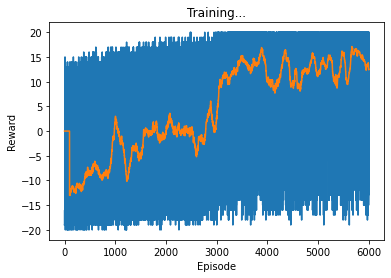

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import torch

plt.figure(2)
plt.clf()
rewards_t = torch.tensor(player.episode_rewards, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(rewards_t.numpy())
# 過去100エピソードの平均報酬
if len(rewards_t) >= 100:
    means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99), means))
    plt.plot(means.numpy())
plt.show()

学習後のAIを用いてゲームを100回プレイさせて、学習結果を確認します。結果からわかることは以下の通りです。

- 約90%の確率で10回の戦闘を生き残っている
- 10回の戦闘を生き残ったパターンにおける逃げる回数は0～2回のケースが多く、なるべく戦闘に勝利しつつも10回の戦闘を生き残ることを最も重視していることが読み取れる

9


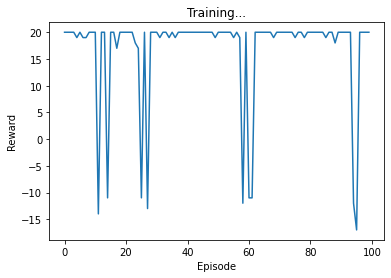

In [9]:
test_env = RPG.Simulation(scenario_code='sample')
result_rewards, dead_count = player.test(test_env, 100)
print(dead_count)

plt.figure(2)
plt.clf()
rewards_t = torch.tensor(result_rewards, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(rewards_t.numpy())
plt.show()

学習済みのAIが1エピソード（戦闘10回終了まで）を行う様子を確認してみましょう。

In [6]:
player.test(test_env, 1, True)


あなたのステータス
HP:40, MP:26
モンスター：コウモリーマ

あなた は 封印 の呪文を唱えた！ コウモリーマ は呪文が使えなくなった！
コウモリーマ は 治療 の呪文を唱えた！ しかし呪文は封じられている！

あなたのステータス
HP:40, MP:24
モンスター：コウモリーマ

あなた の攻撃！ コウモリーマ に 5 のダメージを与えた！
コウモリーマ は 火の玉 の呪文を唱えた！ しかし呪文は封じられている！

あなたのステータス
HP:40, MP:24
モンスター：コウモリーマ

あなた の攻撃！ コウモリーマ に 7 のダメージを与えた！
コウモリーマ の攻撃！ あなた は 3 のダメージを受けた！

あなたのステータス
HP:37, MP:24
モンスター：コウモリーマ

あなた の攻撃！ コウモリーマ に 7 のダメージを与えた！
コウモリーマ は 倒れた！

コウモリーマ を倒した！
残り戦闘回数： 9 回

新たに 魔法コウモリ が出現しました。コマンドを選択してください。

あなたのステータス
HP:37, MP:24
モンスター：魔法コウモリ

あなた の攻撃！ 魔法コウモリ に 8 のダメージを与えた！
魔法コウモリ の攻撃！ あなた は 0 のダメージを受けた！

あなたのステータス
HP:37, MP:24
モンスター：魔法コウモリ

あなた の攻撃！ 魔法コウモリ に 7 のダメージを与えた！
魔法コウモリ は 倒れた！

魔法コウモリ を倒した！
残り戦闘回数： 8 回

新たに 食人植物 が出現しました。コマンドを選択してください。

あなたのステータス
HP:37, MP:24
モンスター：食人植物

あなた の攻撃！ 食人植物 に 7 のダメージを与えた！
食人植物 の攻撃！ あなた は 3 のダメージを受けた！

あなたのステータス
HP:34, MP:24
モンスター：食人植物

あなた の攻撃！ 食人植物 に 9 のダメージを与えた！
食人植物 の攻撃！ あなた は 2 のダメージを受けた！

あなたのステータス
HP:32, MP:24
モンスター：食人植物

あなた の攻撃！ 食人植物 に 12 のダメージを与えた！
食人植物 は 倒れた！

食人植物 を倒した！
残り戦闘回数： 7 回

新たに 魔

([20], 0)

上記から、AIの学習結果を以下の通り読み取ることができます。

1. 大ザリガニには「火の玉」の呪文、その他の敵には通常攻撃を選択しており、攻撃方法を使い分けている。
1. HPが低くなると「治療」の呪文を使って自身のHPを回復している。
1. 相手に応じて「封印」の呪文を使い分けている。呪文が特に強力なコウモリーマには封印の呪文を利用する一方、魔法コウモリや魔法幽霊には封印の呪文を使っていない。

いずれの行動もゲーム作成者が意図した攻略法と同じ、または意図に近い行動をAIが選択しており、AIの学習が成功していると考えられます。

ゲームの内容は"battle/data"フォルダ内のjsonファイルを編集することで、ある程度は自分で調整することができます。

| ファイル名 | 設定内容 |
|--|--|
| player.json | プレイヤーの能力を設定できます |
| enemies.json | 敵の種類・能力などを設定できます |
| scenario.json | ゲームのシナリオを設定できます。<br>具体的には、player.jsonに設定したプレイヤーを一人選び、enemies.jsonに設定した敵から出現する敵を複数設定できます。 |

設定可能なコマンドは以下の通りです。

| コマンド名<br>(ゲーム上の表示) | コマンド名<br>(設定上の名称) | MP消費 | 説明 |
|:--|:--|--:|:--|
| 攻撃 | attack | 0 | 敵に攻撃する |
| 逃げる | escape | 0 | 戦闘から逃げる |
| 治療 | cure | 4 | 自分のHPを回復する<br>プレイヤーが使った場合の方が、回復量が若干大きい |
| 火の玉 | fire | 3 | 相手に防御無視のダメージを与える<br>プレイヤーが使った場合の方が、ダメージが若干大きい |
| 封印 | magic_seal | 2 | 相手の魔法を封印する<br>封印は戦闘終了まで続く |
| 睡眠 | sleep | 2 | 相手を眠らせて行動不能にする<br>ランダムで起きて行動可能になる |

簡単ですが、このアプリの使い方は以上です。
